## Gold Prediction model with Tensorflow 

We're going to predict prices of Gold using a Transformer neural network

## Import data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import datetime
import tempfile
import requests

In [2]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 1000  # how many passes through our data
BATCH_SIZE = 1024  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.

In [3]:
def get_start_date(end_date, days):
    '''
    get the start date from end date
    '''
    return end_date - datetime.timedelta(days=days)



#define the ticker symbol
tickerSymbol = 'GLD'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
end_date = datetime.date.today()
start_date = get_start_date(end_date, SEQ_LEN)
df = tickerData.history(period='1d', start=start_date, end=end_date)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-03,178.949997,179.389999,178.300003,178.919998,7577200,0,0
2020-11-04,178.929993,179.190002,177.660004,178.820007,11117300,0,0
2020-11-05,181.000000,183.289993,180.970001,182.929993,16102800,0,0
2020-11-06,183.399994,183.529999,182.190002,183.190002,10378300,0,0
2020-11-09,176.419998,176.449997,173.639999,175.080002,29800700,0,0


In [4]:
# I got it from https://finance.yahoo.com/quote/GE/history?p=GE&.tsrc=fin-srch

#df = pd.read_csv('2- ge.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])

#define the ticker symbol
tickerSymbol = 'GLD'

#get data on this ticker
df = yf.download(tickerSymbol, start="2005-01-01", end="2020-10-30")[['Open','High','Low','Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [5]:
# Sort DataFrame by date
df = df.reset_index().sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-12-31,43.849998,43.939999,43.730000,43.799999,531600
1,2005-01-03,42.980000,43.169998,42.740002,43.020000,4750400
2,2005-01-04,42.799999,42.910000,42.459999,42.740002,3456800
3,2005-01-05,42.750000,42.880001,42.599998,42.669998,2033600
4,2005-01-06,42.480000,42.560001,42.070000,42.150002,2556400


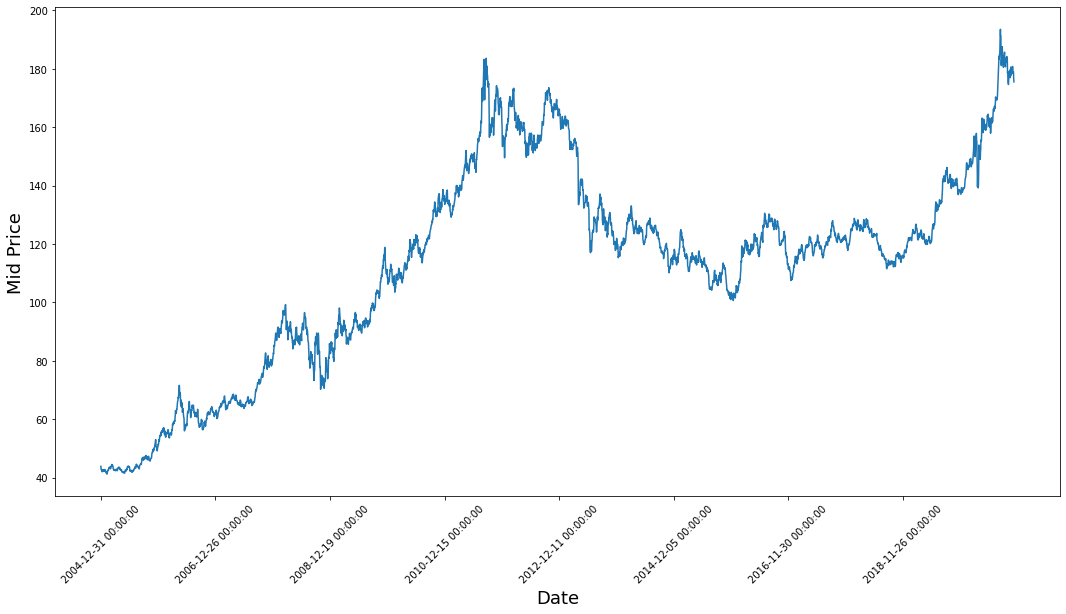

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Data preprocessing 

In [7]:
df['mid'] = (df['Low']+df['High'])/2.0

In [8]:
RATIO_TO_PREDICT = "mid"

In [9]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [10]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [11]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume,mid,future,target
0,2004-12-31,43.849998,43.939999,43.730000,43.799999,531600,43.834999,42.955000,0
1,2005-01-03,42.980000,43.169998,42.740002,43.020000,4750400,42.955000,42.684999,0
2,2005-01-04,42.799999,42.910000,42.459999,42.740002,3456800,42.684999,42.740000,1
3,2005-01-05,42.750000,42.880001,42.599998,42.669998,2033600,42.740000,42.315001,0
4,2005-01-06,42.480000,42.560001,42.070000,42.150002,2556400,42.315001,42.045000,0


In [13]:
df.tail()

,Date,Open,High,Low,Close,Volume,mid,future,target
3981,2020-10-23,179.089996,179.199997,177.759995,178.639999,5919300,178.479996,178.680000,1
3982,2020-10-26,178.750000,179.139999,178.220001,178.550003,5105100,178.680000,178.969994,1
3983,2020-10-27,178.710007,179.429993,178.509995,179.020004,5826900,178.969994,176.145004,0
3984,2020-10-28,176.449997,176.850006,175.440002,176.130005,11734100,176.145004,175.485001,0
3985,2020-10-29,175.020004,176.139999,174.830002,175.399994,8474500,175.485001,NaN,0


In [14]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [15]:
from collections import deque
import numpy as np
import random

In [16]:
train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)# don't need this anymore.

/Users/dachkovski/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
train_df.head()

,mid,target
0,43.834999,0
1,42.955000,0
2,42.684999,1
3,42.740000,0
4,42.315001,0


In [18]:
train_split = train_df[RATIO_TO_PREDICT].values
valid_split = validation_df[RATIO_TO_PREDICT].values
test_split = test_df[RATIO_TO_PREDICT].values

In [19]:
train_data = train_split.reshape(-1,1).copy()
valid_data = valid_split.reshape(-1,1).copy()
test_data = test_split.reshape(-1,1).copy()

In [20]:
# Train the Scaler with data and smooth data
scaler_train = MinMaxScaler()
smoothing_window_size = SEQ_LEN
for di in range(0,len(train_data),smoothing_window_size):
    scaler_train.fit(train_data[di:di+smoothing_window_size])
    train_data[di:di+smoothing_window_size] = scaler_train.transform(train_data[di:di+smoothing_window_size])
    
train_data = train_data.reshape(-1)

In [21]:
scaler_test = MinMaxScaler()
smoothing_window_size = SEQ_LEN
for di in range(0,len(test_data),smoothing_window_size):
    scaler_test.fit(test_data[di:di+smoothing_window_size])
    test_data[di:di+smoothing_window_size] = scaler_test.transform(test_data[di:di+smoothing_window_size])
test_data = test_data.reshape(-1)

In [22]:
scaler_valid = MinMaxScaler()
smoothing_window_size = SEQ_LEN
for di in range(0,len(valid_data),smoothing_window_size):
    scaler_valid.fit(valid_data[di:di+smoothing_window_size])
    valid_data[di:di+smoothing_window_size] = scaler_valid.transform(valid_data[di:di+smoothing_window_size])
valid_data = valid_data.reshape(-1)

In [23]:
# Reshape both train and test data
#test_data = scaler1.transform(test_data).reshape(-1)
#valid_data = scaler1.transform(valid_data).reshape(-1)

In [24]:
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [25]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [26]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [27]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [28]:
y_train.shape

(3129,)

In [29]:
y_valid.shape

(339,)

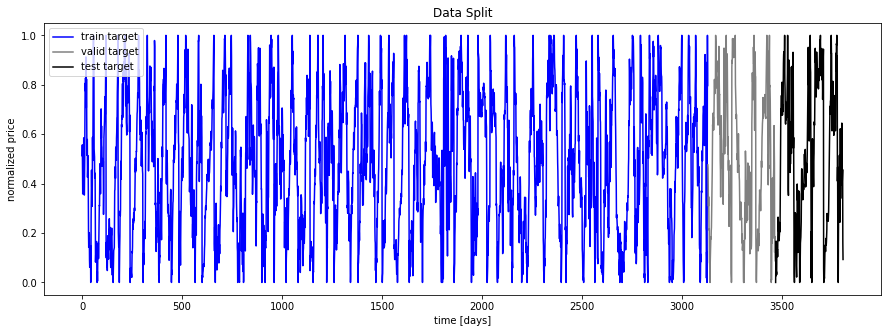

In [30]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Data Split')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [31]:
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

## Model Build (Transformer)

In [32]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
from tensorflow.keras import backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __name__(): # Fix for Tensorflow 
        pass
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        #self.model = keras.models.Model(inputs=src_seq_input, outputs=x)
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
        


In [33]:
# Fix for Tensorflow Model saving
def get_config(self):
    cfg = super().get_config()
    return cfg 

In [34]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1), name="keys")
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid", name="keys_output")(conc)      

    model = Model(inputs = inp, outputs = x, name=NAME)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

In [35]:
multi_head = build_model()

In [36]:
multi_head.summary()

Model: "60-SEQ-1-PRED-1609699806"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
keys (InputLayer)               [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 256)      133120      keys[0][0]                       
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 60, 192)      24576       bidirectional_1[0][0]            
___________________________________________________________________________

## Model Training

In [37]:
history = multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    #callbacks = [checkpoint , lr_reduce]
             )

Epoch 1/5000
4/4 [==============================] - 14s 2s/step - loss: 0.1979 - val_loss: 0.1906
Epoch 2/5000
4/4 [==============================] - 9s 2s/step - loss: 0.1665 - val_loss: 0.0808
Epoch 3/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0953 - val_loss: 0.0992
Epoch 4/5000
4/4 [==============================] - 9s 2s/step - loss: 0.0800 - val_loss: 0.1223
Epoch 5/5000
4/4 [==============================] - 9s 2s/step - loss: 0.0791 - val_loss: 0.0888
Epoch 6/5000
4/4 [==============================] - 9s 2s/step - loss: 0.0805 - val_loss: 0.1121
Epoch 7/5000
4/4 [==============================] - 9s 2s/step - loss: 0.0735 - val_loss: 0.0974
Epoch 8/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0739 - val_loss: 0.1027
Epoch 9/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0728 - val_loss: 0.1051
Epoch 10/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0722 - val_loss: 0.0928
Epoch 11/5000
4/4 [=========

4/4 [==============================] - 8s 2s/step - loss: 0.0166 - val_loss: 0.0191
Epoch 85/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0158 - val_loss: 0.0200
Epoch 86/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0167 - val_loss: 0.0182
Epoch 87/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0152 - val_loss: 0.0189
Epoch 88/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0138 - val_loss: 0.0168
Epoch 89/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0137 - val_loss: 0.0223
Epoch 90/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0172 - val_loss: 0.0209
Epoch 91/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0158 - val_loss: 0.0163
Epoch 92/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0144 - val_loss: 0.0168
Epoch 93/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0144 - val_loss: 0.0168
Epoch 94/5000
4/4 [===============

4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0139
Epoch 168/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0118 - val_loss: 0.0152
Epoch 169/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0120 - val_loss: 0.0153
Epoch 170/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0150
Epoch 171/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0116 - val_loss: 0.0146
Epoch 172/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0115 - val_loss: 0.0142
Epoch 173/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0155
Epoch 174/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0126 - val_loss: 0.0154
Epoch 175/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0125 - val_loss: 0.0143
Epoch 176/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0116 - val_loss: 0.0148
Epoch 177/5000
4/4 [=====

Epoch 250/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0152
Epoch 251/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0140
Epoch 252/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0118 - val_loss: 0.0138
Epoch 253/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0138
Epoch 254/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0141
Epoch 255/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0139
Epoch 256/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0140
Epoch 257/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0142
Epoch 258/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0153
Epoch 259/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0145
Epoch 260/

4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0141
Epoch 333/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0110 - val_loss: 0.0153
Epoch 334/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0142
Epoch 335/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0140
Epoch 336/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0118 - val_loss: 0.0137
Epoch 337/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0154
Epoch 338/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0162
Epoch 339/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0124 - val_loss: 0.0135
Epoch 340/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0120 - val_loss: 0.0140
Epoch 341/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0116 - val_loss: 0.0148
Epoch 342/5000
4/4 [=====

Epoch 415/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0121 - val_loss: 0.0173
Epoch 416/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0124 - val_loss: 0.0144
Epoch 417/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0121 - val_loss: 0.0149
Epoch 418/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0120 - val_loss: 0.0156
Epoch 419/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0115 - val_loss: 0.0145
Epoch 420/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0151
Epoch 421/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0120 - val_loss: 0.0151
Epoch 422/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0132
Epoch 423/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0121 - val_loss: 0.0146
Epoch 424/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0147
Epoch 425/

4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0149
Epoch 498/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0108 - val_loss: 0.0156
Epoch 499/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0141
Epoch 500/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0145
Epoch 501/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0120 - val_loss: 0.0152
Epoch 502/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0161
Epoch 503/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0141
Epoch 504/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0141
Epoch 505/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0142
Epoch 506/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0145
Epoch 507/5000
4/4 [=====

Epoch 580/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0122 - val_loss: 0.0153
Epoch 581/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0121 - val_loss: 0.0139
Epoch 582/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0170
Epoch 583/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0131 - val_loss: 0.0143
Epoch 584/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0145
Epoch 585/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0153
Epoch 586/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0121 - val_loss: 0.0143
Epoch 587/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0121 - val_loss: 0.0185
Epoch 588/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0124 - val_loss: 0.0143
Epoch 589/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0136
Epoch 590/

4/4 [==============================] - 8s 2s/step - loss: 0.0110 - val_loss: 0.0149
Epoch 663/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0110 - val_loss: 0.0173
Epoch 664/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0116 - val_loss: 0.0138
Epoch 665/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0116 - val_loss: 0.0167
Epoch 666/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0143
Epoch 667/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0108 - val_loss: 0.0167
Epoch 668/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0159
Epoch 669/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0168
Epoch 670/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0115 - val_loss: 0.0146
Epoch 671/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0115 - val_loss: 0.0150
Epoch 672/5000
4/4 [=====

Epoch 745/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0140
Epoch 746/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0116 - val_loss: 0.0137
Epoch 747/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0154
Epoch 748/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0136
Epoch 749/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0120 - val_loss: 0.0175
Epoch 750/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0124 - val_loss: 0.0138
Epoch 751/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0121 - val_loss: 0.0146
Epoch 752/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0146
Epoch 753/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0141
Epoch 754/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0118 - val_loss: 0.0142
Epoch 755/

4/4 [==============================] - 8s 2s/step - loss: 0.0123 - val_loss: 0.0165
Epoch 828/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0123 - val_loss: 0.0136
Epoch 829/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0118 - val_loss: 0.0153
Epoch 830/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0108 - val_loss: 0.0140
Epoch 831/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0133
Epoch 832/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0152
Epoch 833/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0138
Epoch 834/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0140
Epoch 835/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0149
Epoch 836/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0136
Epoch 837/5000
4/4 [=====

Epoch 910/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0135
Epoch 911/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0117 - val_loss: 0.0153
Epoch 912/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0108 - val_loss: 0.0137
Epoch 913/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0146
Epoch 914/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0154
Epoch 915/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0140
Epoch 916/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0147
Epoch 917/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0118 - val_loss: 0.0146
Epoch 918/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0140
Epoch 919/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0148
Epoch 920/

4/4 [==============================] - 8s 2s/step - loss: 0.0115 - val_loss: 0.0142
Epoch 993/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0172
Epoch 994/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0152
Epoch 995/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0112 - val_loss: 0.0156
Epoch 996/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0180
Epoch 997/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0150
Epoch 998/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0161
Epoch 999/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0157
Epoch 1000/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0159
Epoch 1001/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0106 - val_loss: 0.0157
Epoch 1002/5000
4/4 [==

4/4 [==============================] - 8s 2s/step - loss: 0.0107 - val_loss: 0.0135
Epoch 1075/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0110 - val_loss: 0.0140
Epoch 1076/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0110 - val_loss: 0.0133
Epoch 1077/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0105 - val_loss: 0.0136
Epoch 1078/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0113 - val_loss: 0.0134
Epoch 1079/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0108 - val_loss: 0.0142
Epoch 1080/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0139
Epoch 1081/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0156
Epoch 1082/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0134
Epoch 1083/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0140
Epoch 1084/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0141
Epoch 1157/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0110 - val_loss: 0.0143
Epoch 1158/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0140
Epoch 1159/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0102 - val_loss: 0.0144
Epoch 1160/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0111 - val_loss: 0.0140
Epoch 1161/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0110 - val_loss: 0.0139
Epoch 1162/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0106 - val_loss: 0.0143
Epoch 1163/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0107 - val_loss: 0.0144
Epoch 1164/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0103 - val_loss: 0.0142
Epoch 1165/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0104 - val_loss: 0.0143
Epoch 1166/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0105 - val_loss: 0.0144
Epoch 1239/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0105 - val_loss: 0.0155
Epoch 1240/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0103 - val_loss: 0.0145
Epoch 1241/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0101 - val_loss: 0.0151
Epoch 1242/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0106 - val_loss: 0.0147
Epoch 1243/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0105 - val_loss: 0.0146
Epoch 1244/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0102 - val_loss: 0.0142
Epoch 1245/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0103 - val_loss: 0.0145
Epoch 1246/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0104 - val_loss: 0.0148
Epoch 1247/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0099 - val_loss: 0.0147
Epoch 1248/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0094 - val_loss: 0.0151
Epoch 1321/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0095 - val_loss: 0.0155
Epoch 1322/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0096 - val_loss: 0.0158
Epoch 1323/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0096 - val_loss: 0.0151
Epoch 1324/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0088 - val_loss: 0.0149
Epoch 1325/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0093 - val_loss: 0.0159
Epoch 1326/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0093 - val_loss: 0.0161
Epoch 1327/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0094 - val_loss: 0.0147
Epoch 1328/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0093 - val_loss: 0.0168
Epoch 1329/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0096 - val_loss: 0.0159
Epoch 1330/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0101 - val_loss: 0.0149
Epoch 1403/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0097 - val_loss: 0.0141
Epoch 1404/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0100 - val_loss: 0.0153
Epoch 1405/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0095 - val_loss: 0.0144
Epoch 1406/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0100 - val_loss: 0.0140
Epoch 1407/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0102 - val_loss: 0.0159
Epoch 1408/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0099 - val_loss: 0.0146
Epoch 1409/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0099 - val_loss: 0.0142
Epoch 1410/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0092 - val_loss: 0.0150
Epoch 1411/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0095 - val_loss: 0.0155
Epoch 1412/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0092 - val_loss: 0.0163
Epoch 1485/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0090 - val_loss: 0.0146
Epoch 1486/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0082 - val_loss: 0.0156
Epoch 1487/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0087 - val_loss: 0.0158
Epoch 1488/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0084 - val_loss: 0.0150
Epoch 1489/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0086 - val_loss: 0.0153
Epoch 1490/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0086 - val_loss: 0.0164
Epoch 1491/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0097 - val_loss: 0.0156
Epoch 1492/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0096 - val_loss: 0.0143
Epoch 1493/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0093 - val_loss: 0.0158
Epoch 1494/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0099 - val_loss: 0.0157
Epoch 1567/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0091 - val_loss: 0.0159
Epoch 1568/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0092 - val_loss: 0.0180
Epoch 1569/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0100 - val_loss: 0.0150
Epoch 1570/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0108 - val_loss: 0.0157
Epoch 1571/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0093 - val_loss: 0.0177
Epoch 1572/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0094 - val_loss: 0.0172
Epoch 1573/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0088 - val_loss: 0.0170
Epoch 1574/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0093 - val_loss: 0.0166
Epoch 1575/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0089 - val_loss: 0.0166
Epoch 1576/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0073 - val_loss: 0.0177
Epoch 1649/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0081 - val_loss: 0.0180
Epoch 1650/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0078 - val_loss: 0.0187
Epoch 1651/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0082 - val_loss: 0.0174
Epoch 1652/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0082 - val_loss: 0.0170
Epoch 1653/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0080 - val_loss: 0.0166
Epoch 1654/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0071 - val_loss: 0.0173
Epoch 1655/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0073 - val_loss: 0.0178
Epoch 1656/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0069 - val_loss: 0.0177
Epoch 1657/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0072 - val_loss: 0.0173
Epoch 1658/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0074 - val_loss: 0.0188
Epoch 1731/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0072 - val_loss: 0.0203
Epoch 1732/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0100 - val_loss: 0.0203
Epoch 1733/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0089 - val_loss: 0.0192
Epoch 1734/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0093 - val_loss: 0.0180
Epoch 1735/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0092 - val_loss: 0.0169
Epoch 1736/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0088 - val_loss: 0.0184
Epoch 1737/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0101 - val_loss: 0.0156
Epoch 1738/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0100 - val_loss: 0.0183
Epoch 1739/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0096 - val_loss: 0.0154
Epoch 1740/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0050 - val_loss: 0.0215
Epoch 1813/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0054 - val_loss: 0.0231
Epoch 1814/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0057 - val_loss: 0.0216
Epoch 1815/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0055 - val_loss: 0.0232
Epoch 1816/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0052 - val_loss: 0.0233
Epoch 1817/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0052 - val_loss: 0.0236
Epoch 1818/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0050 - val_loss: 0.0210
Epoch 1819/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0047 - val_loss: 0.0230
Epoch 1820/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0044 - val_loss: 0.0234
Epoch 1821/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0047 - val_loss: 0.0237
Epoch 1822/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0034 - val_loss: 0.0248
Epoch 1895/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0033 - val_loss: 0.0244
Epoch 1896/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0032 - val_loss: 0.0254
Epoch 1897/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0032 - val_loss: 0.0248
Epoch 1898/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0030 - val_loss: 0.0245
Epoch 1899/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0032 - val_loss: 0.0254
Epoch 1900/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0031 - val_loss: 0.0260
Epoch 1901/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0030 - val_loss: 0.0241
Epoch 1902/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0032 - val_loss: 0.0252
Epoch 1903/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0034 - val_loss: 0.0257
Epoch 1904/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0033 - val_loss: 0.0265
Epoch 1977/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0033 - val_loss: 0.0247
Epoch 1978/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0030 - val_loss: 0.0263
Epoch 1979/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0035 - val_loss: 0.0247
Epoch 1980/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0034 - val_loss: 0.0248
Epoch 1981/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0034 - val_loss: 0.0247
Epoch 1982/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0032 - val_loss: 0.0256
Epoch 1983/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0034 - val_loss: 0.0258
Epoch 1984/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0034 - val_loss: 0.0262
Epoch 1985/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0257
Epoch 1986/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0070 - val_loss: 0.0170
Epoch 2059/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0067 - val_loss: 0.0183
Epoch 2060/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0068 - val_loss: 0.0198
Epoch 2061/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0077 - val_loss: 0.0171
Epoch 2062/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0071 - val_loss: 0.0186
Epoch 2063/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0071 - val_loss: 0.0174
Epoch 2064/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0061 - val_loss: 0.0176
Epoch 2065/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0058 - val_loss: 0.0185
Epoch 2066/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0055 - val_loss: 0.0180
Epoch 2067/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0052 - val_loss: 0.0200
Epoch 2068/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0233
Epoch 2141/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0019 - val_loss: 0.0227
Epoch 2142/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0233
Epoch 2143/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0019 - val_loss: 0.0254
Epoch 2144/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0238
Epoch 2145/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0227
Epoch 2146/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0020 - val_loss: 0.0238
Epoch 2147/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0233
Epoch 2148/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0224
Epoch 2149/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0236
Epoch 2150/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0087 - val_loss: 0.0268
Epoch 2223/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0082 - val_loss: 0.0263
Epoch 2224/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0074 - val_loss: 0.0228
Epoch 2225/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0068 - val_loss: 0.0237
Epoch 2226/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0074 - val_loss: 0.0222
Epoch 2227/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0062 - val_loss: 0.0204
Epoch 2228/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0056 - val_loss: 0.0195
Epoch 2229/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0054 - val_loss: 0.0217
Epoch 2230/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0053 - val_loss: 0.0238
Epoch 2231/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0050 - val_loss: 0.0234
Epoch 2232/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0046 - val_loss: 0.0233
Epoch 2305/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0042 - val_loss: 0.0235
Epoch 2306/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0041 - val_loss: 0.0228
Epoch 2307/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0035 - val_loss: 0.0214
Epoch 2308/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0032 - val_loss: 0.0214
Epoch 2309/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0222
Epoch 2310/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 0.0224
Epoch 2311/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0025 - val_loss: 0.0233
Epoch 2312/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0026 - val_loss: 0.0220
Epoch 2313/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0025 - val_loss: 0.0222
Epoch 2314/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0017 - val_loss: 0.0228
Epoch 2387/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0016 - val_loss: 0.0229
Epoch 2388/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0015 - val_loss: 0.0230
Epoch 2389/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0015 - val_loss: 0.0231
Epoch 2390/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0015 - val_loss: 0.0228
Epoch 2391/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0015 - val_loss: 0.0228
Epoch 2392/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0014 - val_loss: 0.0232
Epoch 2393/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0014 - val_loss: 0.0228
Epoch 2394/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0013 - val_loss: 0.0227
Epoch 2395/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0014 - val_loss: 0.0231
Epoch 2396/5000


4/4 [==============================] - 8s 2s/step - loss: 8.6187e-04 - val_loss: 0.0243
Epoch 2468/5000
4/4 [==============================] - 8s 2s/step - loss: 8.4019e-04 - val_loss: 0.0244
Epoch 2469/5000
4/4 [==============================] - 8s 2s/step - loss: 8.7177e-04 - val_loss: 0.0245
Epoch 2470/5000
4/4 [==============================] - 8s 2s/step - loss: 8.4056e-04 - val_loss: 0.0241
Epoch 2471/5000
4/4 [==============================] - 8s 2s/step - loss: 8.0926e-04 - val_loss: 0.0241
Epoch 2472/5000
4/4 [==============================] - 8s 2s/step - loss: 8.4464e-04 - val_loss: 0.0245
Epoch 2473/5000
4/4 [==============================] - 8s 2s/step - loss: 8.0319e-04 - val_loss: 0.0244
Epoch 2474/5000
4/4 [==============================] - 8s 2s/step - loss: 8.4300e-04 - val_loss: 0.0242
Epoch 2475/5000
4/4 [==============================] - 8s 2s/step - loss: 8.2763e-04 - val_loss: 0.0238
Epoch 2476/5000
4/4 [==============================] - 8s 2s/step - loss: 8.0861

4/4 [==============================] - 8s 2s/step - loss: 7.9605e-04 - val_loss: 0.0264
Epoch 2547/5000
4/4 [==============================] - 8s 2s/step - loss: 7.6081e-04 - val_loss: 0.0266
Epoch 2548/5000
4/4 [==============================] - 8s 2s/step - loss: 7.1638e-04 - val_loss: 0.0267
Epoch 2549/5000
4/4 [==============================] - 8s 2s/step - loss: 6.7820e-04 - val_loss: 0.0262
Epoch 2550/5000
4/4 [==============================] - 8s 2s/step - loss: 7.4978e-04 - val_loss: 0.0264
Epoch 2551/5000
4/4 [==============================] - 8s 2s/step - loss: 7.1300e-04 - val_loss: 0.0265
Epoch 2552/5000
4/4 [==============================] - 8s 2s/step - loss: 6.7283e-04 - val_loss: 0.0261
Epoch 2553/5000
4/4 [==============================] - 8s 2s/step - loss: 6.6867e-04 - val_loss: 0.0260
Epoch 2554/5000
4/4 [==============================] - 8s 2s/step - loss: 6.7858e-04 - val_loss: 0.0254
Epoch 2555/5000
4/4 [==============================] - 8s 2s/step - loss: 6.5000

Epoch 2625/5000
4/4 [==============================] - 8s 2s/step - loss: 5.9368e-04 - val_loss: 0.0276
Epoch 2626/5000
4/4 [==============================] - 8s 2s/step - loss: 5.4410e-04 - val_loss: 0.0284
Epoch 2627/5000
4/4 [==============================] - 8s 2s/step - loss: 5.6782e-04 - val_loss: 0.0280
Epoch 2628/5000
4/4 [==============================] - 8s 2s/step - loss: 5.8829e-04 - val_loss: 0.0282
Epoch 2629/5000
4/4 [==============================] - 8s 2s/step - loss: 5.8768e-04 - val_loss: 0.0286
Epoch 2630/5000
4/4 [==============================] - 8s 2s/step - loss: 5.9001e-04 - val_loss: 0.0290
Epoch 2631/5000
4/4 [==============================] - 8s 2s/step - loss: 6.2324e-04 - val_loss: 0.0280
Epoch 2632/5000
4/4 [==============================] - 8s 2s/step - loss: 5.5727e-04 - val_loss: 0.0274
Epoch 2633/5000
4/4 [==============================] - 8s 2s/step - loss: 5.8166e-04 - val_loss: 0.0279
Epoch 2634/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 6.0405e-04 - val_loss: 0.0273
Epoch 2704/5000
4/4 [==============================] - 8s 2s/step - loss: 6.8216e-04 - val_loss: 0.0270
Epoch 2705/5000
4/4 [==============================] - 8s 2s/step - loss: 7.0815e-04 - val_loss: 0.0266
Epoch 2706/5000
4/4 [==============================] - 8s 2s/step - loss: 6.4769e-04 - val_loss: 0.0273
Epoch 2707/5000
4/4 [==============================] - 8s 2s/step - loss: 5.8147e-04 - val_loss: 0.0274
Epoch 2708/5000
4/4 [==============================] - 8s 2s/step - loss: 6.4013e-04 - val_loss: 0.0264
Epoch 2709/5000
4/4 [==============================] - 8s 2s/step - loss: 7.6336e-04 - val_loss: 0.0262
Epoch 2710/5000
4/4 [==============================] - 8s 2s/step - loss: 7.2766e-04 - val_loss: 0.0270
Epoch 2711/5000
4/4 [==============================] - 8s 2s/step - loss: 7.3986e-04 - val_loss: 0.0272
Epoch 2712/5000
4/4 [==============================] - 8s 2s/step - loss: 6.6250

Epoch 2782/5000
4/4 [==============================] - 8s 2s/step - loss: 4.5426e-04 - val_loss: 0.0275
Epoch 2783/5000
4/4 [==============================] - 8s 2s/step - loss: 4.2396e-04 - val_loss: 0.0278
Epoch 2784/5000
4/4 [==============================] - 8s 2s/step - loss: 3.9598e-04 - val_loss: 0.0276
Epoch 2785/5000
4/4 [==============================] - 8s 2s/step - loss: 4.2066e-04 - val_loss: 0.0277
Epoch 2786/5000
4/4 [==============================] - 8s 2s/step - loss: 4.7532e-04 - val_loss: 0.0275
Epoch 2787/5000
4/4 [==============================] - 8s 2s/step - loss: 4.2908e-04 - val_loss: 0.0273
Epoch 2788/5000
4/4 [==============================] - 8s 2s/step - loss: 4.7114e-04 - val_loss: 0.0273
Epoch 2789/5000
4/4 [==============================] - 8s 2s/step - loss: 4.3566e-04 - val_loss: 0.0279
Epoch 2790/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6688e-04 - val_loss: 0.0281
Epoch 2791/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 4.8361e-04 - val_loss: 0.0280
Epoch 2861/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6404e-04 - val_loss: 0.0281
Epoch 2862/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6577e-04 - val_loss: 0.0278
Epoch 2863/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6382e-04 - val_loss: 0.0270
Epoch 2864/5000
4/4 [==============================] - 8s 2s/step - loss: 4.5129e-04 - val_loss: 0.0273
Epoch 2865/5000
4/4 [==============================] - 8s 2s/step - loss: 4.9683e-04 - val_loss: 0.0266
Epoch 2866/5000
4/4 [==============================] - 8s 2s/step - loss: 5.1815e-04 - val_loss: 0.0274
Epoch 2867/5000
4/4 [==============================] - 8s 2s/step - loss: 4.5177e-04 - val_loss: 0.0281
Epoch 2868/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6181e-04 - val_loss: 0.0281
Epoch 2869/5000
4/4 [==============================] - 8s 2s/step - loss: 4.7889

Epoch 2939/5000
4/4 [==============================] - 8s 2s/step - loss: 4.2318e-04 - val_loss: 0.0279
Epoch 2940/5000
4/4 [==============================] - 8s 2s/step - loss: 4.4207e-04 - val_loss: 0.0270
Epoch 2941/5000
4/4 [==============================] - 8s 2s/step - loss: 4.3276e-04 - val_loss: 0.0262
Epoch 2942/5000
4/4 [==============================] - 8s 2s/step - loss: 4.0257e-04 - val_loss: 0.0275
Epoch 2943/5000
4/4 [==============================] - 8s 2s/step - loss: 3.9380e-04 - val_loss: 0.0262
Epoch 2944/5000
4/4 [==============================] - 8s 2s/step - loss: 4.1310e-04 - val_loss: 0.0264
Epoch 2945/5000
4/4 [==============================] - 8s 2s/step - loss: 4.0891e-04 - val_loss: 0.0262
Epoch 2946/5000
4/4 [==============================] - 8s 2s/step - loss: 3.7074e-04 - val_loss: 0.0269
Epoch 2947/5000
4/4 [==============================] - 8s 2s/step - loss: 4.0240e-04 - val_loss: 0.0270
Epoch 2948/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 6.5636e-04 - val_loss: 0.0267
Epoch 3018/5000
4/4 [==============================] - 8s 2s/step - loss: 6.2086e-04 - val_loss: 0.0270
Epoch 3019/5000
4/4 [==============================] - 8s 2s/step - loss: 5.6152e-04 - val_loss: 0.0273
Epoch 3020/5000
4/4 [==============================] - 8s 2s/step - loss: 5.5399e-04 - val_loss: 0.0270
Epoch 3021/5000
4/4 [==============================] - 8s 2s/step - loss: 5.4853e-04 - val_loss: 0.0277
Epoch 3022/5000
4/4 [==============================] - 8s 2s/step - loss: 5.0247e-04 - val_loss: 0.0270
Epoch 3023/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6718e-04 - val_loss: 0.0275
Epoch 3024/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6680e-04 - val_loss: 0.0283
Epoch 3025/5000
4/4 [==============================] - 8s 2s/step - loss: 4.3478e-04 - val_loss: 0.0284
Epoch 3026/5000
4/4 [==============================] - 8s 2s/step - loss: 4.2904

Epoch 3096/5000
4/4 [==============================] - 8s 2s/step - loss: 4.3967e-04 - val_loss: 0.0285
Epoch 3097/5000
4/4 [==============================] - 8s 2s/step - loss: 4.3389e-04 - val_loss: 0.0270
Epoch 3098/5000
4/4 [==============================] - 8s 2s/step - loss: 3.9519e-04 - val_loss: 0.0273
Epoch 3099/5000
4/4 [==============================] - 8s 2s/step - loss: 3.9384e-04 - val_loss: 0.0273
Epoch 3100/5000
4/4 [==============================] - 8s 2s/step - loss: 4.1303e-04 - val_loss: 0.0276
Epoch 3101/5000
4/4 [==============================] - 8s 2s/step - loss: 5.0424e-04 - val_loss: 0.0282
Epoch 3102/5000
4/4 [==============================] - 8s 2s/step - loss: 5.2727e-04 - val_loss: 0.0283
Epoch 3103/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6270e-04 - val_loss: 0.0285
Epoch 3104/5000
4/4 [==============================] - 8s 2s/step - loss: 5.0535e-04 - val_loss: 0.0283
Epoch 3105/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 0.0044 - val_loss: 0.0237
Epoch 3176/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0071 - val_loss: 0.0238
Epoch 3177/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0107 - val_loss: 0.0246
Epoch 3178/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0142 - val_loss: 0.0233
Epoch 3179/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0147 - val_loss: 0.0201
Epoch 3180/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0136 - val_loss: 0.0190
Epoch 3181/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0132 - val_loss: 0.0204
Epoch 3182/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0133 - val_loss: 0.0206
Epoch 3183/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0124 - val_loss: 0.0199
Epoch 3184/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0123 - val_loss: 0.0209
Epoch 3185/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0084 - val_loss: 0.0187
Epoch 3258/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0084 - val_loss: 0.0215
Epoch 3259/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0084 - val_loss: 0.0209
Epoch 3260/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0079 - val_loss: 0.0185
Epoch 3261/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0077 - val_loss: 0.0193
Epoch 3262/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0079 - val_loss: 0.0194
Epoch 3263/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0077 - val_loss: 0.0178
Epoch 3264/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0075 - val_loss: 0.0206
Epoch 3265/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0074 - val_loss: 0.0204
Epoch 3266/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0075 - val_loss: 0.0217
Epoch 3267/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0034 - val_loss: 0.0212
Epoch 3340/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0041 - val_loss: 0.0228
Epoch 3341/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0051 - val_loss: 0.0210
Epoch 3342/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0048 - val_loss: 0.0214
Epoch 3343/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0053 - val_loss: 0.0211
Epoch 3344/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0058 - val_loss: 0.0187
Epoch 3345/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0069 - val_loss: 0.0183
Epoch 3346/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0057 - val_loss: 0.0190
Epoch 3347/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0078 - val_loss: 0.0230
Epoch 3348/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0100 - val_loss: 0.0227
Epoch 3349/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0025 - val_loss: 0.0230
Epoch 3422/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0022 - val_loss: 0.0221
Epoch 3423/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0022 - val_loss: 0.0222
Epoch 3424/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0020 - val_loss: 0.0228
Epoch 3425/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0023 - val_loss: 0.0223
Epoch 3426/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0023 - val_loss: 0.0229
Epoch 3427/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0228
Epoch 3428/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0238
Epoch 3429/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0233
Epoch 3430/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0236
Epoch 3431/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0010 - val_loss: 0.0250
Epoch 3504/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0241
Epoch 3505/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0243
Epoch 3506/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0247
Epoch 3507/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0248
Epoch 3508/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0012 - val_loss: 0.0241
Epoch 3509/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0012 - val_loss: 0.0243
Epoch 3510/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0010 - val_loss: 0.0248
Epoch 3511/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0244
Epoch 3512/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0247
Epoch 3513/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0012 - val_loss: 0.0235
Epoch 3585/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0226
Epoch 3586/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0036 - val_loss: 0.0252
Epoch 3587/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0052 - val_loss: 0.0253
Epoch 3588/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0118 - val_loss: 0.0256
Epoch 3589/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0124 - val_loss: 0.0252
Epoch 3590/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0130 - val_loss: 0.0253
Epoch 3591/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0119 - val_loss: 0.0212
Epoch 3592/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0109 - val_loss: 0.0204
Epoch 3593/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0114 - val_loss: 0.0185
Epoch 3594/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0028 - val_loss: 0.0255
Epoch 3667/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0249
Epoch 3668/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 0.0258
Epoch 3669/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0247
Epoch 3670/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0026 - val_loss: 0.0250
Epoch 3671/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0261
Epoch 3672/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0028 - val_loss: 0.0254
Epoch 3673/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0025 - val_loss: 0.0264
Epoch 3674/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0025 - val_loss: 0.0257
Epoch 3675/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0026 - val_loss: 0.0257
Epoch 3676/5000


4/4 [==============================] - 8s 2s/step - loss: 0.0028 - val_loss: 0.0243
Epoch 3749/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 0.0241
Epoch 3750/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 0.0249
Epoch 3751/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 0.0245
Epoch 3752/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0028 - val_loss: 0.0244
Epoch 3753/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0024 - val_loss: 0.0243
Epoch 3754/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0026 - val_loss: 0.0238
Epoch 3755/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0025 - val_loss: 0.0243
Epoch 3756/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0247
Epoch 3757/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0027 - val_loss: 0.0247
Epoch 3758/5000


Epoch 3830/5000
4/4 [==============================] - 8s 2s/step - loss: 9.1746e-04 - val_loss: 0.0266
Epoch 3831/5000
4/4 [==============================] - 8s 2s/step - loss: 8.9702e-04 - val_loss: 0.0273
Epoch 3832/5000
4/4 [==============================] - 8s 2s/step - loss: 8.5238e-04 - val_loss: 0.0278
Epoch 3833/5000
4/4 [==============================] - 8s 2s/step - loss: 8.9579e-04 - val_loss: 0.0276
Epoch 3834/5000
4/4 [==============================] - 8s 2s/step - loss: 8.9614e-04 - val_loss: 0.0274
Epoch 3835/5000
4/4 [==============================] - 8s 2s/step - loss: 8.8156e-04 - val_loss: 0.0271
Epoch 3836/5000
4/4 [==============================] - 8s 2s/step - loss: 8.4540e-04 - val_loss: 0.0274
Epoch 3837/5000
4/4 [==============================] - 8s 2s/step - loss: 8.7830e-04 - val_loss: 0.0280
Epoch 3838/5000
4/4 [==============================] - 8s 2s/step - loss: 8.4589e-04 - val_loss: 0.0283
Epoch 3839/5000
4/4 [==============================] - 8s 2s/ste

Epoch 3909/5000
4/4 [==============================] - 8s 2s/step - loss: 5.3985e-04 - val_loss: 0.0298
Epoch 3910/5000
4/4 [==============================] - 8s 2s/step - loss: 5.5132e-04 - val_loss: 0.0298
Epoch 3911/5000
4/4 [==============================] - 8s 2s/step - loss: 4.7220e-04 - val_loss: 0.0292
Epoch 3912/5000
4/4 [==============================] - 8s 2s/step - loss: 5.1080e-04 - val_loss: 0.0291
Epoch 3913/5000
4/4 [==============================] - 8s 2s/step - loss: 5.4820e-04 - val_loss: 0.0301
Epoch 3914/5000
4/4 [==============================] - 8s 2s/step - loss: 5.4442e-04 - val_loss: 0.0297
Epoch 3915/5000
4/4 [==============================] - 8s 2s/step - loss: 5.3006e-04 - val_loss: 0.0294
Epoch 3916/5000
4/4 [==============================] - 8s 2s/step - loss: 4.8934e-04 - val_loss: 0.0292
Epoch 3917/5000
4/4 [==============================] - 8s 2s/step - loss: 4.9887e-04 - val_loss: 0.0296
Epoch 3918/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 3.9280e-04 - val_loss: 0.0295
Epoch 3988/5000
4/4 [==============================] - 8s 2s/step - loss: 4.3412e-04 - val_loss: 0.0297
Epoch 3989/5000
4/4 [==============================] - 8s 2s/step - loss: 4.6404e-04 - val_loss: 0.0302
Epoch 3990/5000
4/4 [==============================] - 8s 2s/step - loss: 4.4641e-04 - val_loss: 0.0305
Epoch 3991/5000
4/4 [==============================] - 8s 2s/step - loss: 4.0001e-04 - val_loss: 0.0304
Epoch 3992/5000
4/4 [==============================] - 8s 2s/step - loss: 4.0652e-04 - val_loss: 0.0305
Epoch 3993/5000
4/4 [==============================] - 8s 2s/step - loss: 4.2906e-04 - val_loss: 0.0301
Epoch 3994/5000
4/4 [==============================] - 8s 2s/step - loss: 4.1784e-04 - val_loss: 0.0302
Epoch 3995/5000
4/4 [==============================] - 8s 2s/step - loss: 4.4686e-04 - val_loss: 0.0315
Epoch 3996/5000
4/4 [==============================] - 8s 2s/step - loss: 4.4306

Epoch 4066/5000
4/4 [==============================] - 8s 2s/step - loss: 3.2245e-04 - val_loss: 0.0301
Epoch 4067/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8819e-04 - val_loss: 0.0295
Epoch 4068/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0365e-04 - val_loss: 0.0301
Epoch 4069/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8497e-04 - val_loss: 0.0300
Epoch 4070/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0445e-04 - val_loss: 0.0295
Epoch 4071/5000
4/4 [==============================] - 8s 2s/step - loss: 3.2884e-04 - val_loss: 0.0300
Epoch 4072/5000
4/4 [==============================] - 8s 2s/step - loss: 3.5242e-04 - val_loss: 0.0298
Epoch 4073/5000
4/4 [==============================] - 8s 2s/step - loss: 3.3373e-04 - val_loss: 0.0295
Epoch 4074/5000
4/4 [==============================] - 8s 2s/step - loss: 3.5368e-04 - val_loss: 0.0297
Epoch 4075/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 3.5081e-04 - val_loss: 0.0302
Epoch 4145/5000
4/4 [==============================] - 8s 2s/step - loss: 3.1622e-04 - val_loss: 0.0304
Epoch 4146/5000
4/4 [==============================] - 8s 2s/step - loss: 2.9260e-04 - val_loss: 0.0303
Epoch 4147/5000
4/4 [==============================] - 8s 2s/step - loss: 2.7539e-04 - val_loss: 0.0304
Epoch 4148/5000
4/4 [==============================] - 8s 2s/step - loss: 2.9630e-04 - val_loss: 0.0304
Epoch 4149/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0543e-04 - val_loss: 0.0311
Epoch 4150/5000
4/4 [==============================] - 8s 2s/step - loss: 2.9665e-04 - val_loss: 0.0303
Epoch 4151/5000
4/4 [==============================] - 8s 2s/step - loss: 2.9748e-04 - val_loss: 0.0298
Epoch 4152/5000
4/4 [==============================] - 8s 2s/step - loss: 2.6367e-04 - val_loss: 0.0308
Epoch 4153/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0039

Epoch 4223/5000
4/4 [==============================] - 8s 2s/step - loss: 4.0708e-04 - val_loss: 0.0308
Epoch 4224/5000
4/4 [==============================] - 8s 2s/step - loss: 4.4781e-04 - val_loss: 0.0305
Epoch 4225/5000
4/4 [==============================] - 8s 2s/step - loss: 4.0977e-04 - val_loss: 0.0301
Epoch 4226/5000
4/4 [==============================] - 8s 2s/step - loss: 3.6301e-04 - val_loss: 0.0304
Epoch 4227/5000
4/4 [==============================] - 8s 2s/step - loss: 3.5647e-04 - val_loss: 0.0307
Epoch 4228/5000
4/4 [==============================] - 8s 2s/step - loss: 3.3428e-04 - val_loss: 0.0309
Epoch 4229/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0424e-04 - val_loss: 0.0305
Epoch 4230/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8037e-04 - val_loss: 0.0311
Epoch 4231/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0041e-04 - val_loss: 0.0311
Epoch 4232/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 0.0014 - val_loss: 0.0287
Epoch 4303/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0011 - val_loss: 0.0289
Epoch 4304/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0013 - val_loss: 0.0290
Epoch 4305/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0014 - val_loss: 0.0270
Epoch 4306/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0017 - val_loss: 0.0282
Epoch 4307/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0023 - val_loss: 0.0298
Epoch 4308/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0019 - val_loss: 0.0310
Epoch 4309/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0019 - val_loss: 0.0287
Epoch 4310/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0017 - val_loss: 0.0279
Epoch 4311/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0015 - val_loss: 0.0293
Epoch 4312/5000


4/4 [==============================] - 8s 2s/step - loss: 2.7701e-04 - val_loss: 0.0268
Epoch 4382/5000
4/4 [==============================] - 8s 2s/step - loss: 2.6536e-04 - val_loss: 0.0273
Epoch 4383/5000
4/4 [==============================] - 8s 2s/step - loss: 2.6254e-04 - val_loss: 0.0279
Epoch 4384/5000
4/4 [==============================] - 8s 2s/step - loss: 2.4179e-04 - val_loss: 0.0282
Epoch 4385/5000
4/4 [==============================] - 8s 2s/step - loss: 2.3111e-04 - val_loss: 0.0284
Epoch 4386/5000
4/4 [==============================] - 8s 2s/step - loss: 2.1149e-04 - val_loss: 0.0284
Epoch 4387/5000
4/4 [==============================] - 8s 2s/step - loss: 2.0743e-04 - val_loss: 0.0282
Epoch 4388/5000
4/4 [==============================] - 8s 2s/step - loss: 1.9111e-04 - val_loss: 0.0278
Epoch 4389/5000
4/4 [==============================] - 8s 2s/step - loss: 1.9814e-04 - val_loss: 0.0277
Epoch 4390/5000
4/4 [==============================] - 8s 2s/step - loss: 2.0229

Epoch 4460/5000
4/4 [==============================] - 7s 2s/step - loss: 2.1543e-04 - val_loss: 0.0294
Epoch 4461/5000
4/4 [==============================] - 8s 2s/step - loss: 2.3450e-04 - val_loss: 0.0297
Epoch 4462/5000
4/4 [==============================] - 8s 2s/step - loss: 2.1015e-04 - val_loss: 0.0296
Epoch 4463/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8326e-04 - val_loss: 0.0295
Epoch 4464/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8426e-04 - val_loss: 0.0291
Epoch 4465/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8541e-04 - val_loss: 0.0290
Epoch 4466/5000
4/4 [==============================] - 8s 2s/step - loss: 2.0695e-04 - val_loss: 0.0295
Epoch 4467/5000
4/4 [==============================] - 8s 2s/step - loss: 1.9261e-04 - val_loss: 0.0294
Epoch 4468/5000
4/4 [==============================] - 8s 2s/step - loss: 1.9248e-04 - val_loss: 0.0297
Epoch 4469/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 2.7713e-04 - val_loss: 0.0306
Epoch 4539/5000
4/4 [==============================] - 8s 2s/step - loss: 3.2795e-04 - val_loss: 0.0306
Epoch 4540/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8348e-04 - val_loss: 0.0296
Epoch 4541/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8364e-04 - val_loss: 0.0302
Epoch 4542/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8358e-04 - val_loss: 0.0305
Epoch 4543/5000
4/4 [==============================] - 8s 2s/step - loss: 2.7130e-04 - val_loss: 0.0286
Epoch 4544/5000
4/4 [==============================] - 8s 2s/step - loss: 2.6311e-04 - val_loss: 0.0293
Epoch 4545/5000
4/4 [==============================] - 8s 2s/step - loss: 2.3871e-04 - val_loss: 0.0302
Epoch 4546/5000
4/4 [==============================] - 8s 2s/step - loss: 2.5428e-04 - val_loss: 0.0304
Epoch 4547/5000
4/4 [==============================] - 8s 2s/step - loss: 2.3298

Epoch 4617/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8591e-04 - val_loss: 0.0308
Epoch 4618/5000
4/4 [==============================] - 8s 2s/step - loss: 1.7403e-04 - val_loss: 0.0309
Epoch 4619/5000
4/4 [==============================] - 8s 2s/step - loss: 1.9834e-04 - val_loss: 0.0310
Epoch 4620/5000
4/4 [==============================] - 8s 2s/step - loss: 1.7616e-04 - val_loss: 0.0314
Epoch 4621/5000
4/4 [==============================] - 8s 2s/step - loss: 1.6990e-04 - val_loss: 0.0314
Epoch 4622/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8782e-04 - val_loss: 0.0311
Epoch 4623/5000
4/4 [==============================] - 8s 2s/step - loss: 1.7492e-04 - val_loss: 0.0306
Epoch 4624/5000
4/4 [==============================] - 8s 2s/step - loss: 1.7573e-04 - val_loss: 0.0306
Epoch 4625/5000
4/4 [==============================] - 8s 2s/step - loss: 1.6545e-04 - val_loss: 0.0307
Epoch 4626/5000
4/4 [==============================] - 8s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 3.4955e-04 - val_loss: 0.0325
Epoch 4696/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0850e-04 - val_loss: 0.0319
Epoch 4697/5000
4/4 [==============================] - 8s 2s/step - loss: 3.3386e-04 - val_loss: 0.0324
Epoch 4698/5000
4/4 [==============================] - 8s 2s/step - loss: 3.6179e-04 - val_loss: 0.0333
Epoch 4699/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8918e-04 - val_loss: 0.0324
Epoch 4700/5000
4/4 [==============================] - 8s 2s/step - loss: 2.7255e-04 - val_loss: 0.0328
Epoch 4701/5000
4/4 [==============================] - 8s 2s/step - loss: 2.6762e-04 - val_loss: 0.0330
Epoch 4702/5000
4/4 [==============================] - 8s 2s/step - loss: 2.4140e-04 - val_loss: 0.0327
Epoch 4703/5000
4/4 [==============================] - 8s 2s/step - loss: 2.1975e-04 - val_loss: 0.0334
Epoch 4704/5000
4/4 [==============================] - 8s 2s/step - loss: 2.4116

Epoch 4774/5000
4/4 [==============================] - 8s 2s/step - loss: 2.1141e-04 - val_loss: 0.0320
Epoch 4775/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8669e-04 - val_loss: 0.0315
Epoch 4776/5000
4/4 [==============================] - 8s 2s/step - loss: 2.2836e-04 - val_loss: 0.0309
Epoch 4777/5000
4/4 [==============================] - 8s 2s/step - loss: 2.4543e-04 - val_loss: 0.0307
Epoch 4778/5000
4/4 [==============================] - 8s 2s/step - loss: 2.9752e-04 - val_loss: 0.0310
Epoch 4779/5000
4/4 [==============================] - 8s 2s/step - loss: 2.6667e-04 - val_loss: 0.0310
Epoch 4780/5000
4/4 [==============================] - 8s 2s/step - loss: 2.8046e-04 - val_loss: 0.0323
Epoch 4781/5000
4/4 [==============================] - 8s 2s/step - loss: 3.0826e-04 - val_loss: 0.0317
Epoch 4782/5000
4/4 [==============================] - 7s 2s/step - loss: 2.4749e-04 - val_loss: 0.0308
Epoch 4783/5000
4/4 [==============================] - 7s 2s/ste

4/4 [==============================] - 8s 2s/step - loss: 1.8500e-04 - val_loss: 0.0326
Epoch 4853/5000
4/4 [==============================] - 8s 2s/step - loss: 1.6801e-04 - val_loss: 0.0326
Epoch 4854/5000
4/4 [==============================] - 8s 2s/step - loss: 1.4313e-04 - val_loss: 0.0331
Epoch 4855/5000
4/4 [==============================] - 8s 2s/step - loss: 1.5517e-04 - val_loss: 0.0332
Epoch 4856/5000
4/4 [==============================] - 8s 2s/step - loss: 1.4509e-04 - val_loss: 0.0320
Epoch 4857/5000
4/4 [==============================] - 8s 2s/step - loss: 1.6711e-04 - val_loss: 0.0326
Epoch 4858/5000
4/4 [==============================] - 8s 2s/step - loss: 1.6888e-04 - val_loss: 0.0336
Epoch 4859/5000
4/4 [==============================] - 8s 2s/step - loss: 1.5433e-04 - val_loss: 0.0330
Epoch 4860/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8070e-04 - val_loss: 0.0329
Epoch 4861/5000
4/4 [==============================] - 8s 2s/step - loss: 1.8844

4/4 [==============================] - 8s 2s/step - loss: 0.0048 - val_loss: 0.0281
Epoch 4932/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0040 - val_loss: 0.0302
Epoch 4933/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0038 - val_loss: 0.0303
Epoch 4934/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0035 - val_loss: 0.0309
Epoch 4935/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0032 - val_loss: 0.0314
Epoch 4936/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0033 - val_loss: 0.0307
Epoch 4937/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0035 - val_loss: 0.0313
Epoch 4938/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0029 - val_loss: 0.0300
Epoch 4939/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0023 - val_loss: 0.0298
Epoch 4940/5000
4/4 [==============================] - 8s 2s/step - loss: 0.0021 - val_loss: 0.0302
Epoch 4941/5000


In [38]:
# save model in simple tensorflow serving model folder
export_path = './backend/models/transformer/1'
tf.keras.models.save_model(
    multi_head,
    export_path,
    overwrite=True,     
    #include_optimizer=True,
    #save_format='tf',
    #signatures=None,
    #options=None
)

INFO:tensorflow:Assets written to: ./backend/models/transformer/1/assets


INFO:tensorflow:Assets written to: ./backend/models/transformer/1/assets


## Tests

#### Loss and Accuracy

dict_keys(['loss', 'val_loss'])


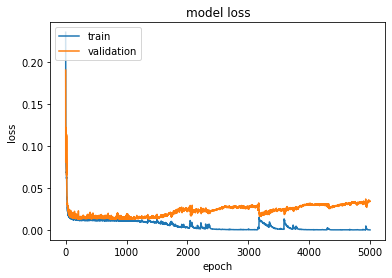

In [40]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
multi_head.predict(X_test)

array([[0.9715154 ],
       [0.2106272 ],
       [0.20072556],
       [0.18833593],
       [0.20868522],
       [0.22680748],
       [0.17998582],
       [0.10849467],
       [0.09707564],
       [0.07094845],
       [0.10140732],
       [0.08999866],
       [0.05643448],
       [0.04564723],
       [0.16733974],
       [0.21860659],
       [0.19861701],
       [0.20500422],
       [0.11695677],
       [0.14507505],
       [0.07878143],
       [0.06197062],
       [0.08800015],
       [0.16280976],
       [0.39870125],
       [0.5114987 ],
       [0.52557576],
       [0.8827665 ],
       [0.6087246 ],
       [0.6812292 ],
       [0.9889376 ],
       [0.90466523],
       [0.99883616],
       [0.98639345],
       [0.58354604],
       [0.43032807],
       [0.7835319 ],
       [0.9568131 ],
       [0.4556384 ],
       [0.9985963 ],
       [0.9999907 ],
       [0.9999273 ],
       [0.9933264 ],
       [0.9957505 ],
       [0.99885416],
       [0.9998429 ],
       [0.99931157],
       [0.648

In [42]:
predicted_stock_price_multi_head = multi_head.predict(X_test)

In [43]:
predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

In [44]:
df = pd.DataFrame({
          'day':np.arange(1,61),
          'actual': test_data[-61:-1].reshape(-1),
          'predicted': predicted_stock_price_multi_head[-61:-1].reshape(-1),
          'actual_shifted': test_data[-62:-2].reshape(-1),})

In [46]:
df['correct?'] = np.where(((df['actual'] > df['actual_shifted']) & (df['predicted'] > df['actual_shifted']))\
                          |((df['actual'] < df['actual_shifted']) & (df['predicted'] < df['actual_shifted'])), True, False)

In [47]:
# accuracy
df['correct?'].mean().round(2)

0.5

#### Visuals

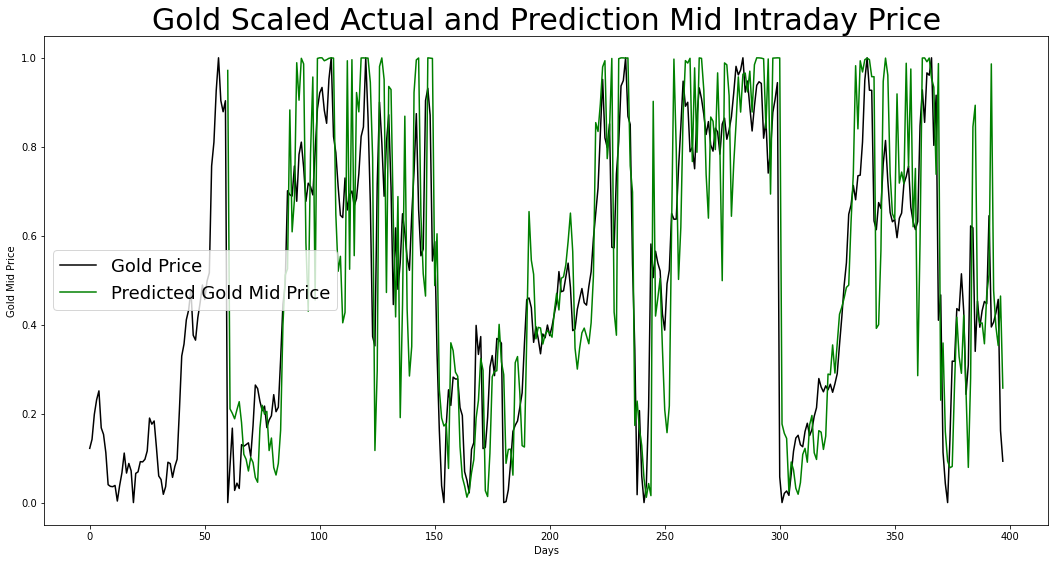

In [48]:
plt.figure(figsize = (18,9))
plt.plot(test_data.reshape(-1, 1), color = 'black', label = 'Gold Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted Gold Mid Price')
plt.title('Gold Scaled Actual and Prediction Mid Intraday Price', fontsize=30)
plt.xlabel('Days')
plt.ylabel('Gold Mid Price')
plt.legend(fontsize=18)
plt.show()

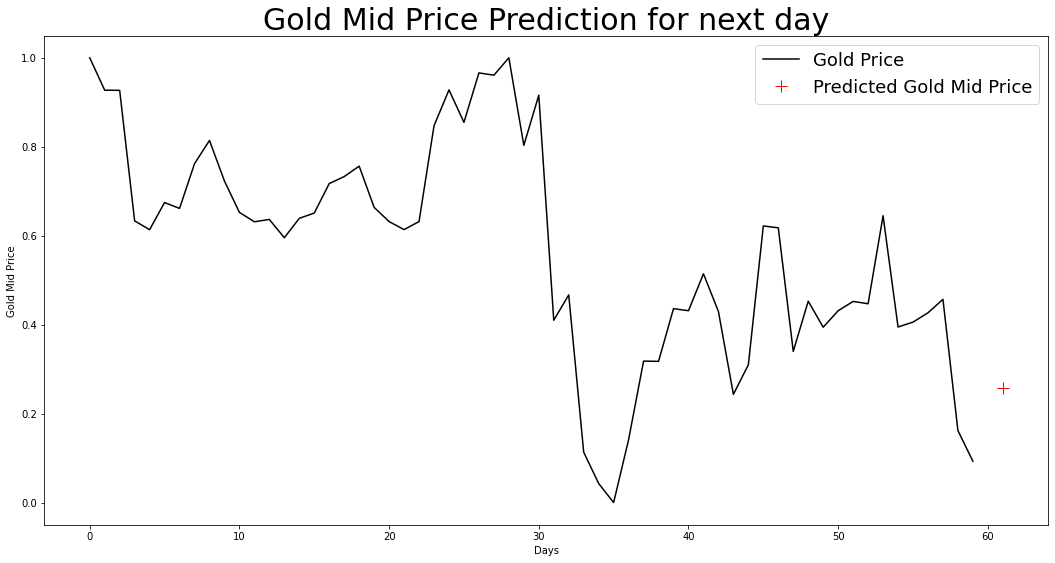

In [49]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(60), test_data[-60:], color = 'black', label = 'Gold Price')
plt.plot(61, predicted_stock_price_multi_head[-1], 'r+', color = 'red', markersize=12, label = 'Predicted Gold Mid Price', )
plt.title('Gold Mid Price Prediction for next day', fontsize=30)
plt.xlabel('Days')
plt.ylabel('Gold Mid Price')
plt.legend(fontsize=18)
plt.show()

#### API Test

In [39]:
endpoint = "http://127.0.0.1:8500" # backend api
json_data = {"model_name": "default", "data": {"keys": [X_train[-1].tolist()]} }
result = requests.post(endpoint, json=json_data)
print(result.json())
pred_output = result.json()['keys_output'][0][0]
pred_output

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8500): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x158643820>: Failed to establish a new connection: [Errno 61] Connection refused'))